# Segmenting and Clustering Districts in Bangkok

My choice is to make a unique notebook for the three different parts of this assignment.

## Scraping the data from the wikipedia page

The idea here is to scrape the data from the wikipedia page. For this, we will use the **urllib** and **BeautifulSoup** libraries in order to reach the page from the URL and then scrape the HTML content. Then, we will use **pandas** to create the dataframe.

In [20]:
# import the urllib library we use to open URLs
import urllib.request

# import the BeautifulSoup library so we can parse HTML documents
from bs4 import BeautifulSoup

# import pandas so we can make dataframes
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Let's begin the workflow: we define the url, open it and then parse the HTML from the page into the BeautifulSoup parse tree format.

In [21]:
# specify which URL/web page we are going to be scraping
url = "https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok"

# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)

# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "lxml")

A fast check of the HTML code shows us that we will find our data in a **table**.  
We need to find which specific table contains the data.

In [22]:
# Display all the tables within the page and identify the right one for us
explore = soup.findAll("table")
#explore

A short exploration of the HTML code of the page shows us that the table containing the data can be identified using the class **wikitable sortable**.

In [23]:
# Assign the HTML table containing the data we want
table = soup.find("table", class_ = "wikitable sortable")
# Find every tr within the table, which represents a row
td = table.findAll("tr")
td[1].findAll("td")

[<td><a href="/wiki/Bang_Bon_District" title="Bang Bon District">Bang Bon</a></td>,
 <td>50</td>,
 <td>10150</td>,
 <td>บางบอน</td>,
 <td align="right">105,161</td>,
 <td>4
 </td>,
 <td>13.6592
 </td>,
 <td>100.3991
 </td>]

Let's now make the dataframe. We will create one list per column and fill them with the values of the table. Then, we'll build the dataframe out of them.

In [24]:
districts_tab = []
postal_code_tab = []
latitude_tab = []
longitude_tab = []
popu_tab = []

for i in range(1,51):
    districts_tab.append(str(td[i].findAll("td")[0])[str(td[i].findAll("td")[0]).find('">')+2:str(td[i].findAll("td")[0]).find('</a>')])
    postal_code_tab.append(str(td[i].findAll("td")[2]).replace("<td>","").replace("</td>","").replace("\n",""))
    latitude_tab.append(float(str(td[i].findAll("td")[6]).replace("<td>","").replace("</td>","").replace("\n","")))
    longitude_tab.append(float(str(td[i].findAll("td")[7]).replace("<td>","").replace("</td>","").replace("\n","")))
    popu_tab.append(float(str(td[i].findAll("td")[4]).replace('<td align="right">',"").replace("</td>","").replace("\n","").replace(",","")))

In [25]:
# Create the dataframe
df = pd.DataFrame(districts_tab, columns = ['District'])
df['PostalCode'] = postal_code_tab
df['Population'] = popu_tab
df['Latitude'] = latitude_tab
df['Longitude'] = longitude_tab

df.head()

,District,PostalCode,Population,Latitude,Longitude
0,Bang Bon,10150,105161.0,13.659200,100.399100
1,Bang Kapi,10240,148465.0,13.765833,100.647778
2,Bang Khae,10160,191781.0,13.696111,100.409444
3,Bang Khen,10220,189539.0,13.873889,100.596389
4,Bang Kho Laem,10120,94956.0,13.693333,100.502500


In [26]:
df.shape

(50, 5)

## Visualize map

Now we will use geopy to find the coordinates of Bangkok and then create a map with folium.

In [27]:
from geopy.geocoders import Nominatim

address = 'Bangkok'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Bangkok are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Bangkok are 13.7542529, 100.493087.


In [28]:
import folium

map_bkk = folium.Map(location=[latitude, longitude], zoom_start=10.5)

for lat, lng, pop, district in zip(df['Latitude'], df['Longitude'], df['Population'], df['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bkk)  
    
map_bkk

Now let's use foursquare to explore the map.

In [29]:
CLIENT_ID = '4YGSH1HVBSINQK2SM1E43ZO2CXMECXHABBR0L2VAFWMYPTUB' # your Foursquare ID
CLIENT_SECRET = 'JWZYGGL3DAQSNX25JKN1QO3Y1MVJ3KWBO4HP4IK4ZCOE0NLX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4YGSH1HVBSINQK2SM1E43ZO2CXMECXHABBR0L2VAFWMYPTUB
CLIENT_SECRET:JWZYGGL3DAQSNX25JKN1QO3Y1MVJ3KWBO4HP4IK4ZCOE0NLX


Let's create a function that gets the top 100 venues of a district that are within a 500 miles radius, and make it a dataframe.

In [30]:
import requests

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            500, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
bkk_venues = getNearbyVenues(names=df['District'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Bang Bon
Bang Kapi
Bang Khae
Bang Khen
Bang Kho Laem
Bang Khun Thian
Bang Na
Bang Phlat
Bang Rak
Bang Sue
Bangkok Noi
Bangkok Yai
Bueng Kum
Chatuchak
Chom Thong
Din Daeng
Don Mueang
Dusit
Huai Khwang
Khan Na Yao
Khlong Sam Wa
Khlong San
Khlong Toei
Lak Si
Lat Krabang
Lat Phrao
Min Buri
Nong Chok
Nong Khaem
Pathum Wan
Phasi Charoen
Phaya Thai
Phra Khanong
Phra Nakhon
Pom Prap Sattru Phai
Prawet
Rat Burana
Ratchathewi
Sai Mai
Samphanthawong
Saphan Sung
Sathon
Suan Luang
Taling Chan
Thawi Watthana
Thon Buri
Thung Khru
Wang Thonglang
Watthana
Yan Nawa


Let's check the size of the resulting dataframe.

In [32]:
print(bkk_venues.shape)
bkk_venues.head()

(1147, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bang Bon,13.6592,100.3991,ขาหมูบางหว้า,13.657136,100.395230,Thai Restaurant
1,Bang Bon,13.6592,100.3991,Irashaimase Japanese Restaurant,13.658358,100.401403,Japanese Restaurant
2,Bang Bon,13.6592,100.3991,Lotus Express (โลตัส เอ็กซ์เพรส),13.657839,100.397243,Convenience Store
3,Bang Bon,13.6592,100.3991,บ้านพลูหลวง เอกชัย,13.658482,100.398440,Asian Restaurant
4,Bang Bon,13.6592,100.3991,The Rich Plaza,13.658626,100.397684,Shopping Plaza


Let's check how many venues were returned for each district.

In [33]:
bkk_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Bang Bon,10,10,10,10,10,10
Bang Kapi,24,24,24,24,24,24
Bang Khae,12,12,12,12,12,12
Bang Khen,12,12,12,12,12,12
Bang Kho Laem,16,16,16,16,16,16
Bang Khun Thian,40,40,40,40,40,40
Bang Na,9,9,9,9,9,9
Bang Phlat,10,10,10,10,10,10
Bang Rak,28,28,28,28,28,28


Let's find out how many unique categories can be curated from all the returned venues

In [34]:
print('There are {} uniques categories. \n'.format(len(bkk_venues['Venue Category'].unique())))
print('These categories are: \n{}'.format(bkk_venues['Venue Category'].unique()))

There are 169 uniques categories. 

These categories are: 
['Thai Restaurant' 'Japanese Restaurant' 'Convenience Store'
 'Asian Restaurant' 'Shopping Plaza' 'Shopping Mall' 'Noodle House'
 'Restaurant' 'Automotive Shop' 'Neighborhood' 'Flea Market'
 'Massage Studio' 'Coffee Shop' 'Market' 'Multiplex' 'Museum'
 'Shabu-Shabu Restaurant' 'BBQ Joint' 'Hotpot Restaurant'
 'Som Tum Restaurant' 'Ramen Restaurant' 'Intersection' 'Food Truck'
 'Buffet' 'Breakfast Spot' 'Bus Station' 'Fast Food Restaurant'
 'Supermarket' 'Wings Joint' 'Garden Center' 'Vietnamese Restaurant'
 'Tunnel' 'Garden' 'Café' 'Seafood Restaurant' 'Chinese Restaurant'
 'Dessert Shop' 'Gym / Fitness Center' 'Fried Chicken Joint' 'Bakery'
 'Clothing Store' 'Mobile Phone Shop' 'Department Store' 'Building'
 'Pizza Place' 'Park' 'Juice Bar' 'Bookstore' 'Spa' 'Electronics Store'
 'Sports Club' 'Badminton Court' 'Tea Room' 'Cocktail Bar' 'Dog Run'
 'Bus Stop' 'Hotel' 'Hostel' 'Bar' 'Hotel Bar' 'Soup Place' 'Playground'
 'Steakho

It's now time to start analyzing and processing the data for the clustering.

Let's make a OHE'd dataframe.

In [35]:
# one hot encoding
bkk_onehot = pd.get_dummies(bkk_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
bkk_onehot['District'] = bkk_venues['District'] 

# move district column to the first column
fixed_columns = [bkk_onehot.columns[-1]] + list(bkk_onehot.columns[:-1])
bkk_onehot = bkk_onehot[fixed_columns]

bkk_onehot.head()

,District,American Restaurant,Art Gallery,Asian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Badminton Court,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Canal,Cantonese Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Coworking Space,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donburi Restaurant,Dumpling Restaurant,Duty-free Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Floating Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gay Bar,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Organic Grocery,Other Nightlife,Other Repair Shop,Park,Pastry Shop,Pedestrian Plaza,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Pub,Ramen Restaurant,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Rest Area,Restaurant,Roof Deck,Sake Bar,Salad Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Soccer Stadium,Som Tum Restaurant,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toll Plaza,Tonkatsu Restaurant,Tour Provider,Train Station,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bang Bon,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [36]:
bkk_onehot.shape

(1147, 170)

Next, let's group rows by district and by taking the mean of the frequency of occurrence of each category

In [37]:
bkk_grouped = bkk_onehot.groupby('District').mean().reset_index()
bkk_grouped.head()

,District,American Restaurant,Art Gallery,Asian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Badminton Court,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Building,Burger Joint,Bus Line,Bus Station,Bus Stop,Cafeteria,Café,Canal,Cantonese Restaurant,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Coworking Space,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donburi Restaurant,Dumpling Restaurant,Duty-free Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Floating Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gay Bar,German Restaurant,Gift Shop,Golf Driving Range,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Intersection,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lounge,Market,Massage Studio,Medical Center,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Organic Grocery,Other Nightlife,Other Repair Shop,Park,Pastry Shop,Pedestrian Plaza,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Pub,Ramen Restaurant,Recording Studio,Recreation Center,Residential Building (Apartment / Condo),Rest Area,Restaurant,Roof Deck,Sake Bar,Salad Place,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Soccer Field,Soccer Stadium,Som Tum Restaurant,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Toll Plaza,Tonkatsu Restaurant,Tour Provider,Train Station,Tunnel,Udon Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Store,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,Bang Bon,0.0,0.0,0.100000,0.0,0.1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.100000,0.1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,Bang Kapi,0.0,0.0,0.041667,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.041667,0.0,0.0,0.0,0.041667,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.041667,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.041667,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.041667,0.0,0.0,0.041667,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.041667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.

In [38]:
bkk_grouped.shape

(50, 170)

Let's print each district along with the top 5 most common venues.

In [39]:
num_top_venues = 5

for hood in bkk_grouped['District']:
    print("----"+hood+"----")
    temp = bkk_grouped[bkk_grouped['District'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bang Bon----
                 venue  freq
0      Thai Restaurant   0.2
1     Asian Restaurant   0.1
2      Automotive Shop   0.1
3  Japanese Restaurant   0.1
4         Noodle House   0.1


----Bang Kapi----
               venue  freq
0       Noodle House  0.17
1  Convenience Store  0.08
2  Hotpot Restaurant  0.04
3          Multiplex  0.04
4        Flea Market  0.04


----Bang Khae----
               venue  freq
0  Convenience Store  0.33
1        Coffee Shop  0.17
2    Thai Restaurant  0.08
3        Wings Joint  0.08
4       Noodle House  0.08


----Bang Khen----
               venue  freq
0   Asian Restaurant  0.17
1  Convenience Store  0.17
2      Garden Center  0.08
3             Tunnel  0.08
4               Café  0.08


----Bang Kho Laem----
                venue  freq
0        Noodle House  0.19
1         Coffee Shop  0.12
2  Chinese Restaurant  0.12
3     Thai Restaurant  0.12
4   Convenience Store  0.06


----Bang Khun Thian----
                  venue  freq
0   Japanese Re

First, let's write a function to sort the venues in descending order. Then let's create the new dataframe and display the top 10 venues for each district.

In [99]:
import numpy as np

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['District'] = bkk_grouped['District']

for ind in np.arange(bkk_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bkk_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,Thai Restaurant,Shopping Plaza,Asian Restaurant,Convenience Store,Automotive Shop,Shopping Mall,Japanese Restaurant,Restaurant,Noodle House,Yoga Studio
1,Bang Kapi,Noodle House,Convenience Store,Hotpot Restaurant,Market,Ramen Restaurant,Coffee Shop,Neighborhood,Flea Market,Museum,Multiplex
2,Bang Khae,Convenience Store,Coffee Shop,Shopping Mall,Fast Food Restaurant,Supermarket,Thai Restaurant,Noodle House,Wings Joint,Discount Store,Dim Sum Restaurant
3,Bang Khen,Convenience Store,Asian Restaurant,Vietnamese Restaurant,Som Tum Restaurant,Tunnel,Coffee Shop,Garden,Garden Center,Noodle House,Café
4,Bang Kho Laem,Noodle House,Chinese Restaurant,Coffee Shop,Thai Restaurant,Shopping Mall,Fast Food Restaurant,Seafood Restaurant,Supermarket,Hotpot Restaurant,Convenience Store
5,Bang Khun Thian,Japanese Restaurant,Thai Restaurant,Pizza Place,Bakery,Noodle House,Dessert Shop,Restaurant,Gym / Fitness Center,Badminton Court,Bookstore
6,Bang Na,Noodle House,Asian Restaurant,Coffee Shop,Café,Chinese Restaurant,Seafood Restaurant,Thai Restaurant,Yoga Studio,Food & Drink Shop,Food
7,Bang Phlat,Convenience Store,Clothing Store,Fast Food Restaurant,Dog Run,Bakery,Bus Stop,Cocktail Bar,Som Tum Restaurant,Café,Food Court
8,Bang Rak,Noodle House,Hotel,Chinese Restaurant,Som Tum Restaurant,Café,Breakfast Spot,Thai Restaurant,Soup Place,Coffee Shop,Bakery
9,Bang Sue,Noodle House,Thai Restaurant,Coffee Shop,Hotpot Restaurant,Playground,Convenience Store,Badminton Court,Bar,Seafood Restaurant,Food


Now, based on this, we finally can begin the clustering. Let's to it with 5 clusters.

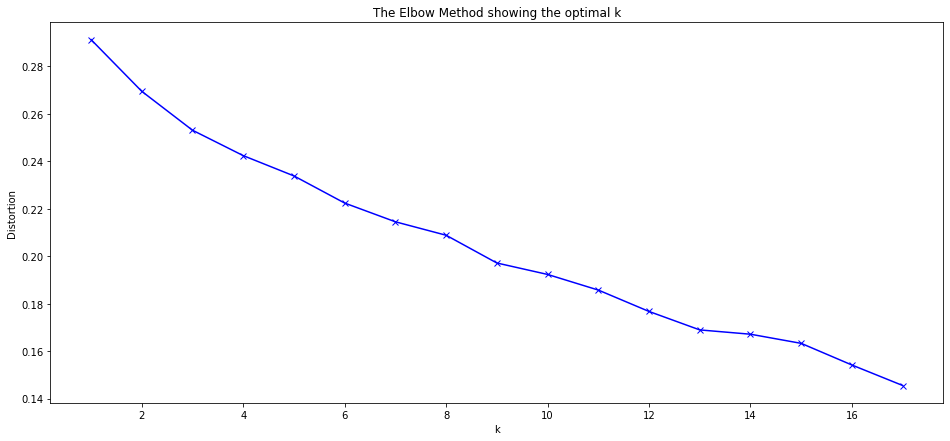

In [100]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,18)

bkk_grouped_clustering = bkk_grouped.drop('District', 1)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(bkk_grouped_clustering)
    kmeans.fit(bkk_grouped_clustering)
    distortions.append(sum(np.min(cdist(bkk_grouped_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1)) / bkk_grouped_clustering.shape[0])

# Plot the elbow
plt.figure(figsize=(16,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [101]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bkk_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([2, 2, 2, 2, 3, 1, 3, 2, 3, 3, 3, 3, 2, 1, 1, 2, 2, 3, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1, 1, 3, 1, 2, 3, 3, 2,
       2, 3, 2, 1, 1, 1])

In [102]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bkk_merged = df

# merge bkk_merged with toronto_data to add latitude/longitude for each district
bkk_merged = bkk_merged.join(neighborhoods_venues_sorted.set_index('District'), on='District')

# drop the NaN values
bkk_merged.dropna(inplace = True)
bkk_merged.head()

,District,PostalCode,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,10150,105161.0,13.659200,100.399100,2,Thai Restaurant,Shopping Plaza,Asian Restaurant,Convenience Store,Automotive Shop,Shopping Mall,Japanese Restaurant,Restaurant,Noodle House,Yoga Studio
1,Bang Kapi,10240,148465.0,13.765833,100.647778,2,Noodle House,Convenience Store,Hotpot Restaurant,Market,Ramen Restaurant,Coffee Shop,Neighborhood,Flea Market,Museum,Multiplex
2,Bang Khae,10160,191781.0,13.696111,100.409444,2,Convenience Store,Coffee Shop,Shopping Mall,Fast Food Restaurant,Supermarket,Thai Restaurant,Noodle House,Wings Joint,Discount Store,Dim Sum Restaurant
3,Bang Khen,10220,189539.0,13.873889,100.596389,2,Convenience Store,Asian Restaurant,Vietnamese Restaurant,Som Tum Restaurant,Tunnel,Coffee Shop,Garden,Garden Center,Noodle House,Café
4,Bang Kho Laem,10120,94956.0,13.693333,100.502500,3,Noodle House,Chinese Restaurant,Coffee Shop,Thai Restaurant,Shopping Mall,Fast Food Restaurant,Seafood Restaurant,Supermarket,Hotpot Restaurant,Convenience Store


Finally, we will display the clusters on the map. Let's go.

In [103]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(1-i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bkk_merged['Latitude'], bkk_merged['Longitude'], bkk_merged['District'], bkk_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Analyzing the clusters

The idea is now to see what's in those different clusters. It is very likely that each cluster will represent a type of district.

### Cluster 0

In [104]:
bkk_merged.loc[bkk_merged['Cluster Labels'] == 0, bkk_merged.columns[[1] + list(range(5, bkk_merged.shape[1]))]]

,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,10250,0,Convenience Store,Halal Restaurant,Yoga Studio,Electronics Store,Food Court,Food & Drink Shop,Food,Floating Market,Flea Market,Fast Food Restaurant


This cluster is the outsider that we will ignore.

### Cluster 1

In [105]:
bkk_merged.loc[bkk_merged['Cluster Labels'] == 1, bkk_merged.columns[[1] + list(range(5, bkk_merged.shape[1]))]]

,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,10150,1,Japanese Restaurant,Thai Restaurant,Pizza Place,Bakery,Noodle House,Dessert Shop,Restaurant,Gym / Fitness Center,Badminton Court,Bookstore
13,10900,1,Coffee Shop,Thai Restaurant,Flea Market,Bed & Breakfast,Café,Massage Studio,Fast Food Restaurant,Cocktail Bar,Noodle House,Beer Bar
14,10150,1,American Restaurant,Coffee Shop,Rest Area,Toll Plaza,Dim Sum Restaurant,Dessert Shop,Food & Drink Shop,Food,Floating Market,Flea Market
19,10230,1,Japanese Restaurant,Bakery,Ice Cream Shop,Coffee Shop,Shabu-Shabu Restaurant,Steakhouse,Thai Restaurant,Som Tum Restaurant,Fast Food Restaurant,BBQ Joint
20,10510,1,Pub,Japanese Restaurant,Convenience Store,Coffee Shop,Chinese Restaurant,Thai Restaurant,Department Store,Halal Restaurant,Health & Beauty Service,Floating Market
21,10600,1,Coffee Shop,Dessert Shop,Noodle House,Hotel Bar,Thai Restaurant,Clothing Store,Art Gallery,Historic Site,Café,Hotel
22,10110,1,Pier,Bar,Canal,Thai Restaurant,Karaoke Bar,Food Court,Recording Studio,Diner,Electronics Store,Food & Drink Shop
23,10210,1,Coffee Shop,Fast Food Restaurant,Japanese Restaurant,Thai Restaurant,Steakhouse,Hotpot Restaurant,Supermarket,Convenience Store,Noodle House,Canal
24,10520,1,Thai Restaurant,Asian Restaurant,Hotel,Flea Market,Coffee Shop,Boat or Ferry,Restaurant,Café,Noodle House,Yoga Studio
25,10230,1,Noodle House,Som Tum Restaurant,Café,Coffee Shop,Thai Restaurant,Hotpot Restaurant,Gift Shop,Flea Market,Soccer Field,Sake Bar


This seems to be the cluster with the most diversified venues, either coffee shops, art galleries, noodle houses, markets... This means these districts are probably the ones with the highest economic activity.  

As one of Bangkok's main sources of income is tourism and expat businesses, the appropriate demographics to open a non-local restaurant might be found there. Moreover, many of the district in this cluster are where you'll find popular touristic markets or huge malls (Chatuchak, Phayathai, Ratchathewi...).

### Cluster 2

In [106]:
bkk_merged.loc[bkk_merged['Cluster Labels'] == 2, bkk_merged.columns[[1] + list(range(5, bkk_merged.shape[1]))]]

,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10150,2,Thai Restaurant,Shopping Plaza,Asian Restaurant,Convenience Store,Automotive Shop,Shopping Mall,Japanese Restaurant,Restaurant,Noodle House,Yoga Studio
1,10240,2,Noodle House,Convenience Store,Hotpot Restaurant,Market,Ramen Restaurant,Coffee Shop,Neighborhood,Flea Market,Museum,Multiplex
2,10160,2,Convenience Store,Coffee Shop,Shopping Mall,Fast Food Restaurant,Supermarket,Thai Restaurant,Noodle House,Wings Joint,Discount Store,Dim Sum Restaurant
3,10220,2,Convenience Store,Asian Restaurant,Vietnamese Restaurant,Som Tum Restaurant,Tunnel,Coffee Shop,Garden,Garden Center,Noodle House,Café
7,10700,2,Convenience Store,Clothing Store,Fast Food Restaurant,Dog Run,Bakery,Bus Stop,Cocktail Bar,Som Tum Restaurant,Café,Food Court
12,10240,2,Market,Convenience Store,Furniture / Home Store,New American Restaurant,Gourmet Shop,Yoga Studio,Food & Drink Shop,Food,Floating Market,Flea Market
15,10400,2,Convenience Store,Stadium,Fried Chicken Joint,Food Court,Park,Recreation Center,Bus Station,Sports Club,Hotel,Bar
16,10210,2,Thai Restaurant,Convenience Store,Hotel,Pet Store,Restaurant,Flea Market,Buffet,Food Truck,Spa,Soup Place
27,10530,2,Convenience Store,Food Truck,Asian Restaurant,Flea Market,Shopping Mall,Grocery Store,Park,Other Repair Shop,Thai Restaurant,Duty-free Shop
29,10330,2,Convenience Store,Noodle House,Dessert Shop,Asian Restaurant,Chinese Restaurant,Seafood Restaurant,Thai Restaurant,Japanese Restaurant,Som Tum Restaurant,Gym / Fitness Center


Cluster of convenience stores, hotels and basic entertainement. Seems like it could be from a residential local area.

### Cluster 3

In [107]:
bkk_merged.loc[bkk_merged['Cluster Labels'] == 3, bkk_merged.columns[[1] + list(range(5, bkk_merged.shape[1]))]]

,PostalCode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,10120,3,Noodle House,Chinese Restaurant,Coffee Shop,Thai Restaurant,Shopping Mall,Fast Food Restaurant,Seafood Restaurant,Supermarket,Hotpot Restaurant,Convenience Store
6,10260,3,Noodle House,Asian Restaurant,Coffee Shop,Café,Chinese Restaurant,Seafood Restaurant,Thai Restaurant,Yoga Studio,Food & Drink Shop,Food
8,10500,3,Noodle House,Hotel,Chinese Restaurant,Som Tum Restaurant,Café,Breakfast Spot,Thai Restaurant,Soup Place,Coffee Shop,Bakery
9,10800,3,Noodle House,Thai Restaurant,Coffee Shop,Hotpot Restaurant,Playground,Convenience Store,Badminton Court,Bar,Seafood Restaurant,Food
10,10700,3,Noodle House,Som Tum Restaurant,Thai Restaurant,Coffee Shop,Steakhouse,Dessert Shop,Chinese Restaurant,Pizza Place,Park,Shabu-Shabu Restaurant
11,10600,3,Noodle House,Coffee Shop,Asian Restaurant,Dessert Shop,Farmers Market,Photography Studio,Soup Place,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant
17,10300,3,Noodle House,Asian Restaurant,Dessert Shop,Convenience Store,Coffee Shop,Som Tum Restaurant,Market,Food Court,Food & Drink Shop,Food
18,10310,3,Noodle House,Som Tum Restaurant,Hotel,Bed & Breakfast,Convenience Store,Chinese Restaurant,Restaurant,Spa,Supermarket,Thai Restaurant
38,10220,3,Noodle House,Steakhouse,Bar,Thai Restaurant,Yoga Studio,Food Court,Food & Drink Shop,Food,Floating Market,Flea Market
41,10120,3,Noodle House,Asian Restaurant,Convenience Store,Dessert Shop,Chinese Restaurant,Thai Restaurant,Coffee Shop,Bakery,Steakhouse,Farmers Market


This cluster is also focused on food, but mainly noodle houses. In Bangkok, noodle houses are small local restaurants, often held by a couple or a family, where the capacity is around 20 people. So these are district where people go to eat. Local food-focused districts. This isn't what we're looking for either.

## Conclusion

We are looking for a district in which we can open our restaurant. Since we aren't locals, we need a district popular to the expats, and preferably dynamic. This brings us to cluster 3 (label 2). Any district of this cluster close to the center of Bangkok might be a fit for what we're looking for.  
  
Let's aim for the districts with the highest amount of hostels/hotels. **Phayathai (10400)** seems to be a good pick: it has hostels and hotels at the 3rd and 4th places, which means it hosts many tourists, and steakhouses (something that isn't local) are among the most common venues.